In [336]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
diffusion="5.0percent"
# diffusion="0.05percent"
# file_id = "1"
# file_id = "2954"
file_id = "2638"

# hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_EFilt_smear_{file_id}.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_EFilt_{diffusion}_smear_{file_id}.h5", "MC/hits")

hits_true = pd.read_hdf(f"../data/ATPC_Bi/ATPC_Bi_ion_{pressure}bar_Efilt_smear_{file_id}_4.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_Bi/ATPC_Bi_ion_{pressure}bar_Efilt_{diffusion}_smear_{file_id}_4.h5", "MC/hits")

# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+3000


# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_5.0percent_smear_3273_1.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

,event_id,x,y,z,energy
0,26390000002,1445.970581,2729.424561,4919.076660,0.000025
1,26390000002,1431.348999,2747.884277,4921.604980,0.000025
2,26390000002,1429.842773,2736.223389,4922.269531,0.000025
3,26390000002,1434.849121,2728.794434,4922.606445,0.000025
4,26390000002,1440.386475,2737.324219,4922.885742,0.000025
...,...,...,...,...,...
273113,26390000204,2417.039795,-470.902740,5908.342285,0.000496
273114,26390000204,2400.959229,-461.380829,5908.770020,0.000050
273115,26390000204,2425.793457,-471.355377,5910.171387,0.000099
273116,26390000204,2409.243408,-474.262604,5918.931641,0.000025


[26390000002 26390000003 26390000007 26390000011 26390000014 26390000017
 26390000018 26390000019 26390000022 26390000023 26390000026 26390000029
 26390000041 26390000046 26390000047 26390000050 26390000055 26390000068
 26390000069 26390000073 26390000075 26390000076 26390000082 26390000083
 26390000091 26390000095 26390000101 26390000104 26390000108 26390000110
 26390000113 26390000114 26390000117 26390000118 26390000126 26390000129
 26390000130 26390000131 26390000132 26390000135 26390000137 26390000139
 26390000141 26390000142 26390000146 26390000147 26390000150 26390000154
 26390000156 26390000158 26390000159 26390000160 26390000163 26390000166
 26390000167 26390000168 26390000172 26390000173 26390000175 26390000177
 26390000180 26390000181 26390000183 26390000184 26390000185 26390000186
 26390000187 26390000190 26390000191 26390000193 26390000194 26390000197
 26390000201 26390000202 26390000204]


In [337]:
# eid=195330
eid=event_list[8]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

,event_id,x,y,z,energy
5611,26390000022,1863.216675,1451.242798,0.240786,0.000050
5612,26390000022,1863.474609,1452.528442,1.753628,0.001587
5613,26390000022,1864.294678,1455.520020,6.521513,0.006671
5614,26390000022,1864.684326,1456.216553,7.906395,0.000074
5615,26390000022,1865.240479,1457.351929,10.143434,0.001190
...,...,...,...,...,...
6623,26390000022,2205.002930,1243.502930,1345.528076,0.002827
6624,26390000022,2206.625000,1242.175171,1345.882568,0.000422
6625,26390000022,2214.886475,1235.726685,1346.135986,0.000744
6626,26390000022,2209.213135,1240.155884,1346.294189,0.002505


In [338]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist, voxel_size, det_size  = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
# energy_threshold=0
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)
print("The voxel size is:",           voxel_size)

# energy_threshold = 0.0004

mean_sigma = diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean())

# The expected diffusion is less than vox size so replace
if (mean_sigma < 1.5*voxel_size):
    mean_sigma = 1.5*voxel_size

# Create the bins ---- 
xbw  = mean_sigma
xmin = -det_size - mean_sigma/2 
xmax = det_size  + mean_sigma/2

ybw  = mean_sigma
ymin = -det_size - mean_sigma/2 
ymax = det_size  + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

Diffussion smear is:  0.314 mm/sqrt(cm)
Energy threshold is:  0.2 keV
diffision scale factor is:  6
Radius scale factor is:  7
Hit grouping factor is:  5
Tortuosity distance scale is: 105.0
The voxel size is: 10


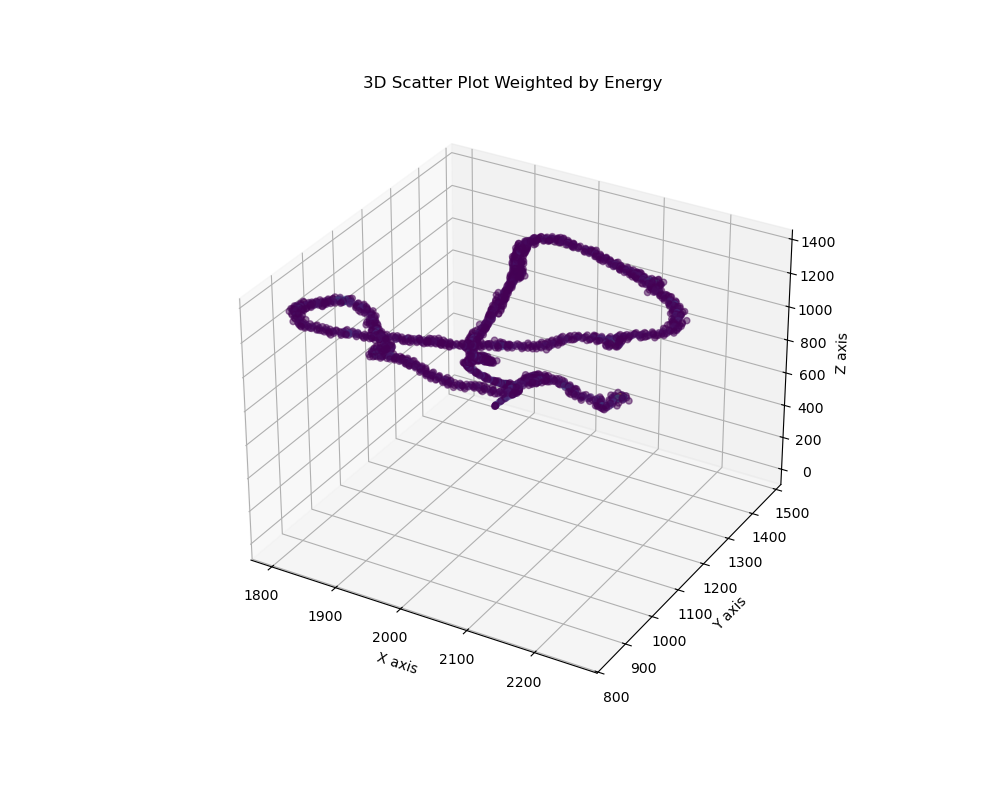

In [339]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [340]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(data)

,event_id,x,y,z,energy
0,26390000022,1800.365112,911.885925,1293.871582,0.000050
1,26390000022,1800.804199,900.927002,1294.937866,0.000025
2,26390000022,1801.174805,917.026489,1301.067139,0.000347
3,26390000022,1801.329712,907.169678,1301.927979,0.003298
4,26390000022,1801.688721,901.244080,1302.113281,0.002778
...,...,...,...,...,...
2035,26390000022,2255.927979,1150.780884,1309.894043,0.000198
2036,26390000022,2256.045410,1178.150513,1311.379883,0.000099
2037,26390000022,2256.260986,1159.223145,1318.285767,0.000620
2038,26390000022,2256.320801,1160.181885,1312.257080,0.000918


Mean z: 1072.3525  diffusion =  19.50965843014024
Mean Sigma:  19.50965843014024


,x,y,z,energy,group_id
0,1808.276367,917.684570,1301.912842,0.046213,0
1,1809.598633,890.763306,1308.998047,0.013535,0
2,1817.585205,869.919983,1314.841431,0.007443,0
3,1816.715698,938.549988,1291.199097,0.010323,0
4,1820.659668,958.367065,1280.975342,0.008641,0
...,...,...,...,...,...
150,2168.672119,1287.460571,1337.533447,0.105884,0
151,2177.564453,1288.253174,1326.293579,0.009482,0
152,2169.615967,1017.239380,1050.377808,0.007621,0
153,2169.919922,1103.079590,1257.509766,0.003874,0


155 2.470352802105481


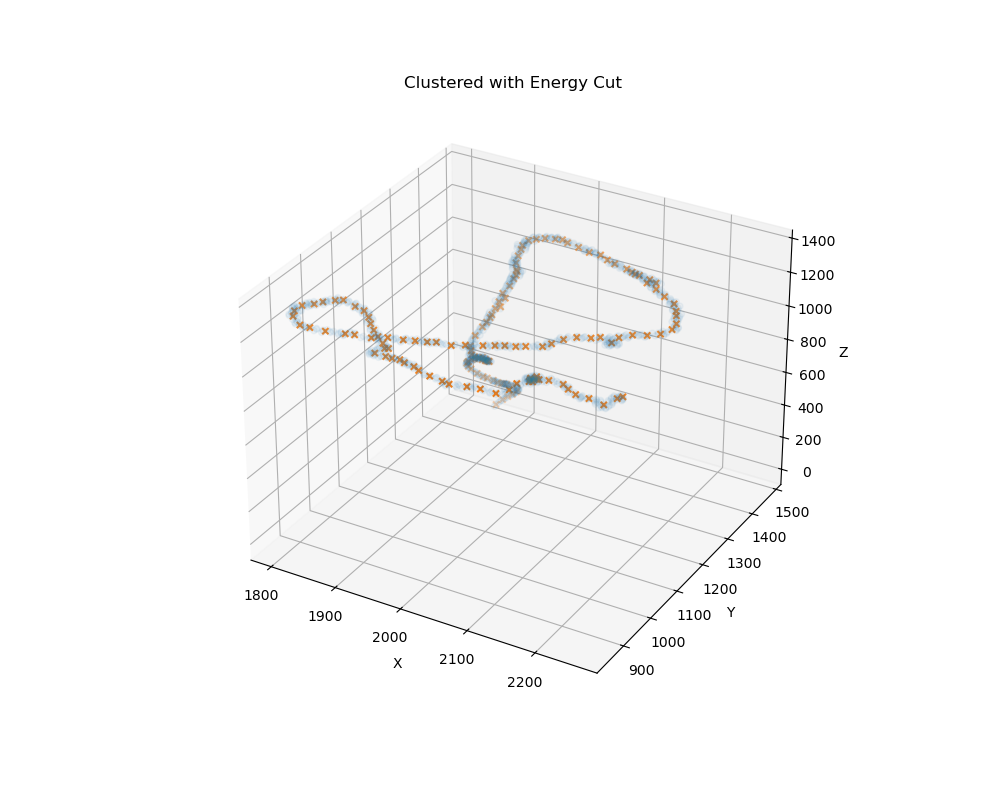

In [341]:

# display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)


# Apply grouping
data_copy = data.copy()

df_merged = CutandRedistibuteEnergy(data_copy, energy_threshold)

mean_sigma_group = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())

if (mean_sigma_group < 1.5*voxel_size):
    mean_sigma_group = 1.5*voxel_size

df_merged = GroupHits(df_merged, mean_sigma_group)

# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Unclustered
# for gid in sorted(df_merged.group_id.unique()):
#     # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
#     # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
#     temp_df = df_merged[df_merged.group_id == gid]
#     ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

# Clustered
for gid in sorted(node_centers_df.group_id.unique()):
    ax.scatter(df_merged['x'], df_merged['y'], df_merged['z'], marker='o',alpha=0.05)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = node_centers_df[node_centers_df.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Clustered with Energy Cut')
plt.show()



In [342]:


databin = node_centers_df.copy()
databin["event_id"] = eid

# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)



# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'], row['group_id'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'group_id' : row['group_id'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['group_id'] = row['group_id']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear, group_id = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum'],           # Sum energy
        'group_id' : int(group_id)
    })

# Create final DataFrame
databin = pd.DataFrame(result)

# then sort it based on the x,y,z
# databin = databin.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,2.639000e+10,1805.754991,908.310703,1307.147115,1808.276367,917.684570,1301.912842,0.046213,0
1,2.639000e+10,1805.754991,888.801045,1307.147115,1809.598633,890.763306,1308.998047,0.013535,0
2,2.639000e+10,1825.264650,869.291386,1307.147115,1817.585205,869.919983,1314.841431,0.007443,0
3,2.639000e+10,1825.264650,947.330020,1287.637456,1816.715698,938.549988,1291.199097,0.010323,0
4,2.639000e+10,1825.264650,966.839679,1287.637456,1820.659668,958.367065,1280.975342,0.008641,0
...,...,...,...,...,...,...,...,...,...
136,2.639000e+10,2156.928843,1025.368654,1053.521555,2157.372559,1020.724609,1062.404663,0.028956,0
137,2.639000e+10,2176.438501,1278.994214,1346.166432,2169.824097,1279.203857,1340.348389,0.108560,0
138,2.639000e+10,2176.438501,1278.994214,1326.656773,2177.564453,1288.253174,1326.293579,0.009482,0
139,2.639000e+10,2176.438501,1025.368654,1053.521555,2169.615967,1017.239380,1050.377808,0.007621,0


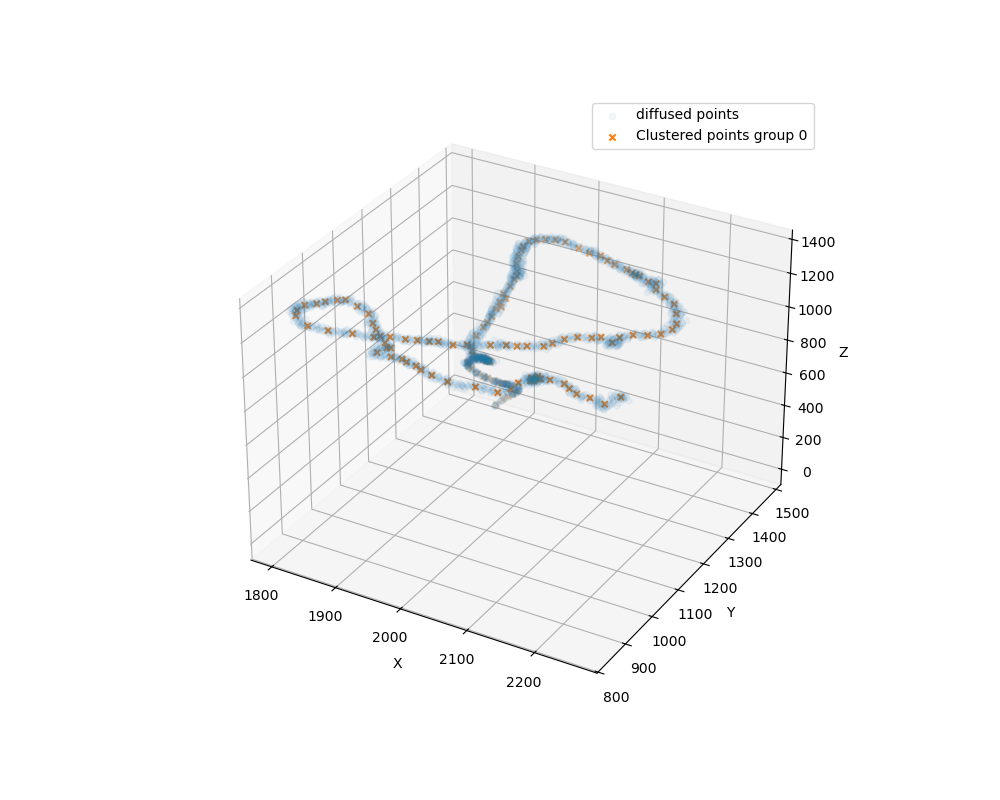

In [343]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05, label = "diffused points")
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")


for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x', label = f"Clustered points group {gid}")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()
plt.savefig("plots/clustering/clustered_hits1.pdf")

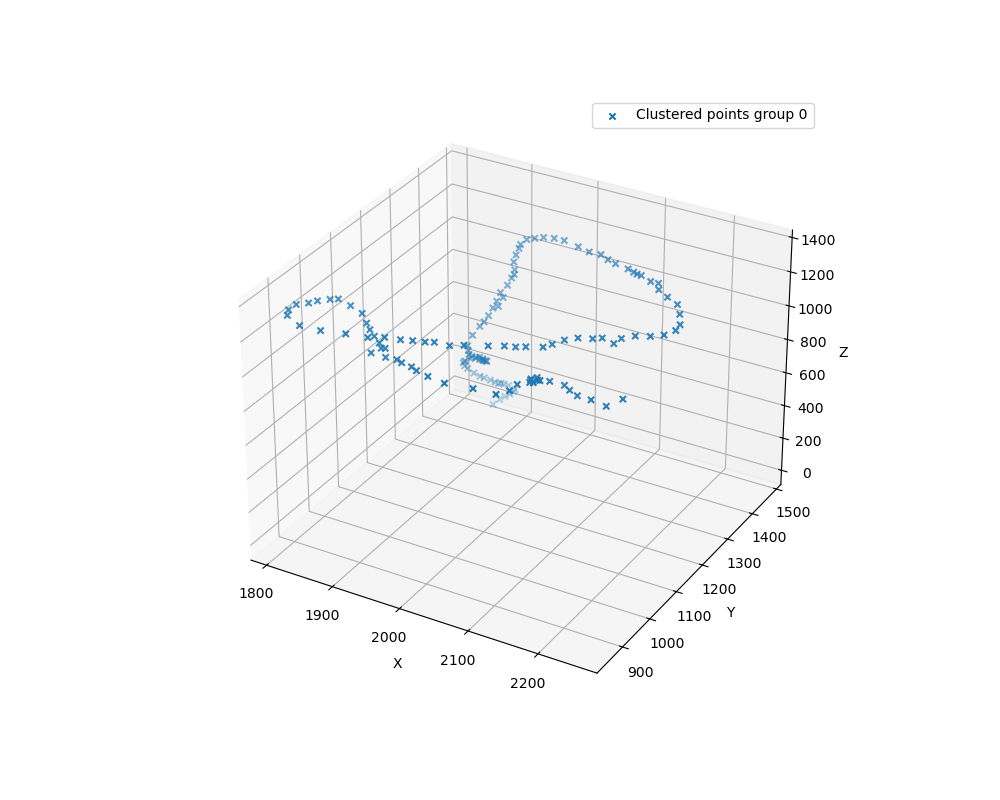

In [344]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x', label = f"Clustered points group {gid}")

# ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Clustered Points', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()
plt.savefig("plots/clustering/clustered_hits2.pdf")

In [345]:
display(databin)

# databin.to_hdf("../data/test/test.h5", "MC/hits")

,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,2.639000e+10,1805.754991,908.310703,1307.147115,1808.276367,917.684570,1301.912842,0.046213,0
1,2.639000e+10,1805.754991,888.801045,1307.147115,1809.598633,890.763306,1308.998047,0.013535,0
2,2.639000e+10,1825.264650,869.291386,1307.147115,1817.585205,869.919983,1314.841431,0.007443,0
3,2.639000e+10,1825.264650,947.330020,1287.637456,1816.715698,938.549988,1291.199097,0.010323,0
4,2.639000e+10,1825.264650,966.839679,1287.637456,1820.659668,958.367065,1280.975342,0.008641,0
...,...,...,...,...,...,...,...,...,...
136,2.639000e+10,2156.928843,1025.368654,1053.521555,2157.372559,1020.724609,1062.404663,0.028956,0
137,2.639000e+10,2176.438501,1278.994214,1346.166432,2169.824097,1279.203857,1340.348389,0.108560,0
138,2.639000e+10,2176.438501,1278.994214,1326.656773,2177.564453,1288.253174,1326.293579,0.009482,0
139,2.639000e+10,2176.438501,1025.368654,1053.521555,2169.615967,1017.239380,1050.377808,0.007621,0


Diffussion smear is:  0.314 mm/sqrt(cm)
Energy threshold is:  0.2 keV
diffision scale factor is:  6
Radius scale factor is:  7
Hit grouping factor is:  5
Tortuosity distance scale is: 105.0
The voxel size is: 10
The det half_length is:  3091.169274839764
Median distance to the closest row: 20.56598051949757
Distances to iterate over [  1  11  21  31  41  52  62  72  82  92 103 113 123 133 143]
Dist Thresh 92.212
Pass Flag: True
The primary track is:  0
         event_id            x            y            z    energy  group_id  \
0    2.639000e+10  1864.726562  1456.500244     8.396694  0.016747         0   
1    2.639000e+10  1871.186279  1466.185791    34.326828  0.010680         0   
2    2.639000e+10  1877.978516  1470.323242    55.222668  0.011368         0   
3    2.639000e+10  1884.647461  1472.683350    73.354034  0.014019         0   
4    2.639000e+10  1890.425293  1473.598999    94.116135  0.007086         0   
..            ...          ...          ...          ...       

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,,
13,2.639000e+10,1864.726562,1456.500244,8.396694,0.016747,0,13,1,0,0.000000,0.000000,1.007763,0.111777
17,2.639000e+10,1871.186279,1466.185791,34.326828,0.010680,0,17,1,0,28.423751,139.342491,1.011637,0.146216
21,2.639000e+10,1877.978516,1470.323242,55.222668,0.011368,0,21,1,0,50.781950,10.035161,1.044400,0.310758
25,2.639000e+10,1884.647461,1472.683350,73.354034,0.014019,0,25,1,0,70.244514,4.284157,1.062105,0.421895
31,2.639000e+10,1890.425293,1473.598999,94.116135,0.007086,0,31,1,0,91.815016,6.476209,1.062105,0.421895
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2.639000e+10,2157.372559,1020.724609,1062.404663,0.028956,0,121,1,0,3251.227886,42.035947,1.335360,0.808891
123,2.639000e+10,2169.615967,1017.239380,1050.377808,0.007621,0,123,1,0,3268.740542,12.406417,1.335360,0.808891
128,2.639000e+10,2189.079102,1016.340698,1051.098755,0.042925,0,128,1,0,3288.237747,47.025322,1.267045,0.624288


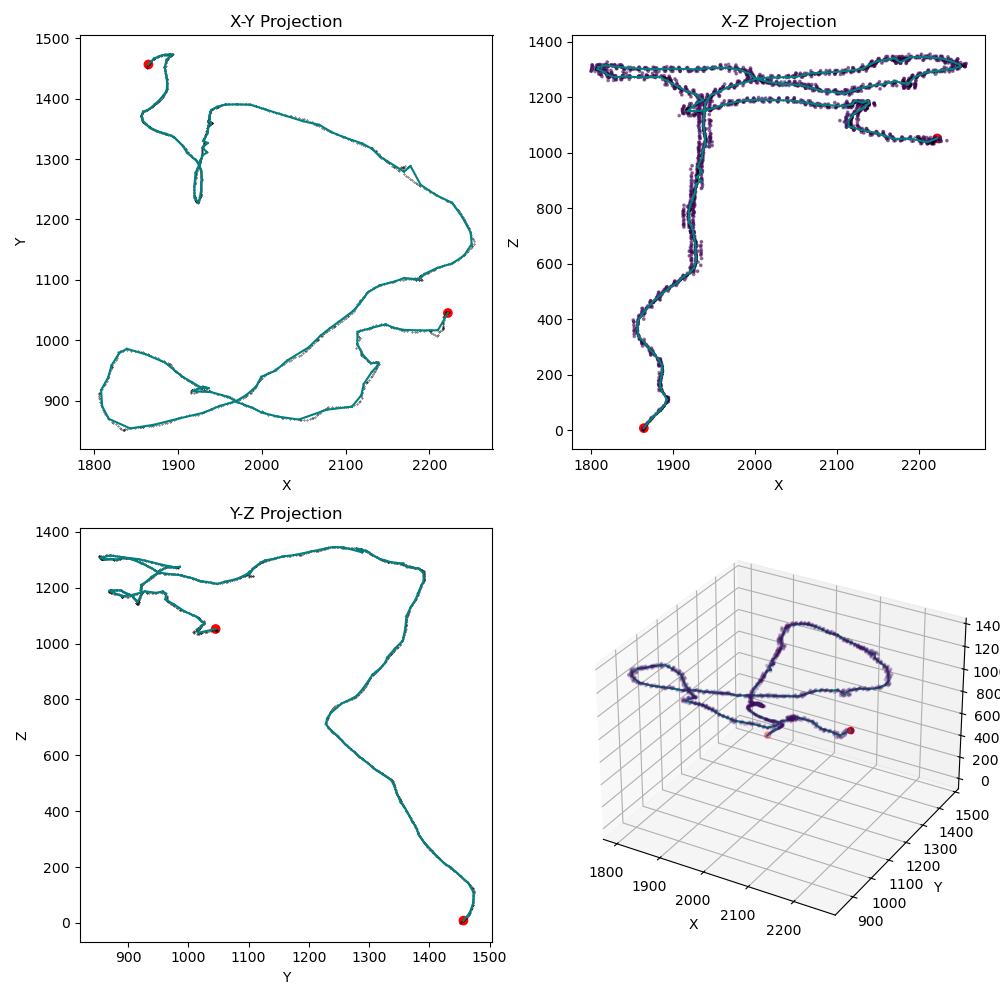

In [346]:
# Apply the tracking reconstruction

# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag, contained = RunTracking(databin[["event_id", "x", "y", "z", "energy", "group_id"]], 0, pressure, diffusion, 0)

df.index = df.id

display(df)

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
# ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
# ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
ax_3D.scatter(df_merged.x, df_merged.y, df_merged.z, c=df_merged.energy, marker='o', alpha=0.2,s=3)
ax_3D.set_title("")


plt.tight_layout()
plt.show()

In [347]:
temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure
temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
display(temp_meta)

Swapping the blob names


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,2.639000e+10,0,1,134,13,3346.281,2.470353,0.537653,0.288594,0.402048,0.144348,1.311553,1.040421,0.836354,0.301626,Primary


Text(0, 0.5, 'Angle')

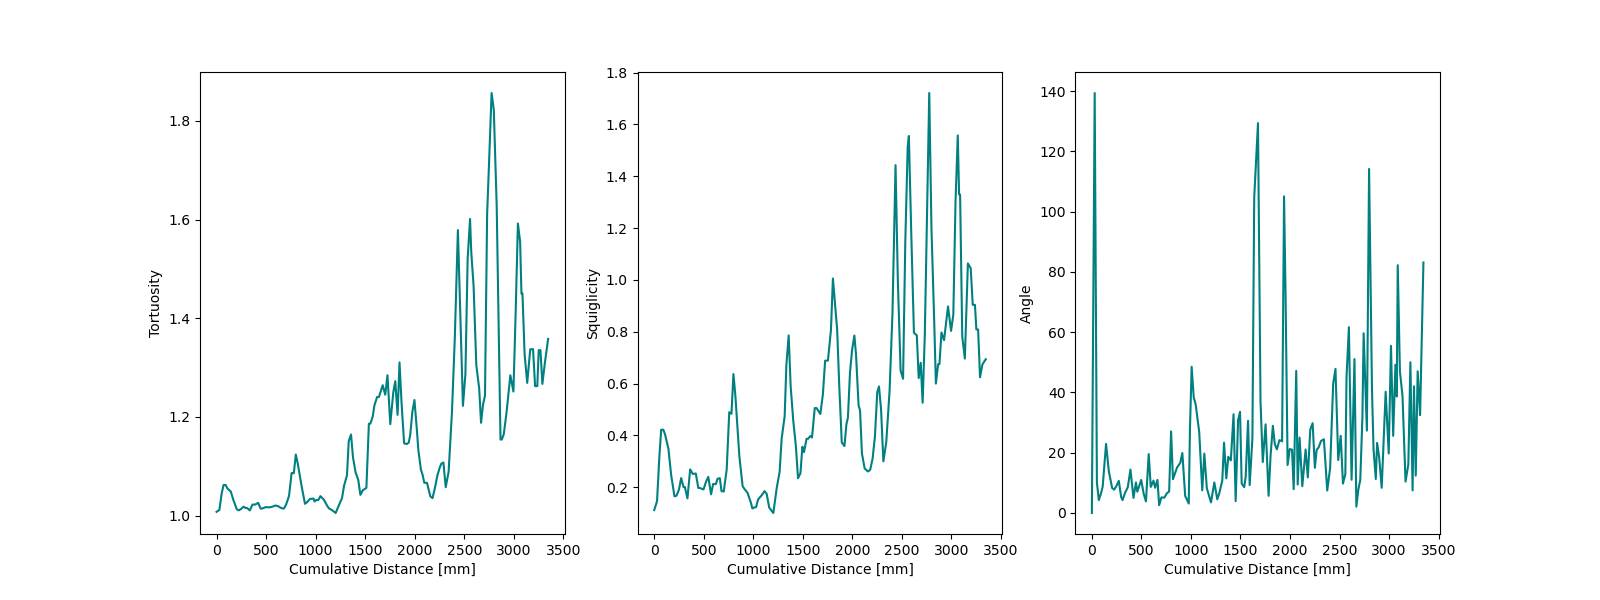

In [348]:

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Tortuosity"], c="Teal")
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Squiglicity"], c="Teal")
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["angle"], c="Teal")
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("Angle")